In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
data_import = pd.read_csv('../Data/LT_DU_data_for_ML_All_variations_optimized_outliers.csv') # All variations of categorical and numeric transformations
data_import.columns

Index(['lpk', 'hourly_rate', 'experience', 'weeks', 'vacation',
       'esize_class_ord', 'esize_class_orig', 'esize_class_oh_1_49',
       'esize_class_oh_50_249', 'esize_class_oh_GT_250', 'gender_orig',
       'gender_M', 'age_class_ord', 'age_class_orig', 'age_class_oh_14-29',
       'age_class_oh_30-39', 'age_class_oh_40-49', 'age_class_oh_50-59',
       'age_class_oh_60+', 'education_ord', 'education_orig',
       'education_oh_G1', 'education_oh_G2', 'education_oh_G3',
       'education_oh_G4', 'outlier', 'nace_orig', 'nace_B', 'nace_C', 'nace_D',
       'nace_E', 'nace_F', 'nace_G', 'nace_H', 'nace_I', 'nace_J', 'nace_K',
       'nace_L', 'nace_M', 'nace_N', 'nace_O', 'nace_P', 'nace_Q', 'nace_R',
       'nace_S', 'hourly_rate_norm', 'experience_sc', 'weeks_sc',
       'vacation_sc'],
      dtype='object')

# Data selection and filtering

## Parameters

In [3]:
# Normalize 'hourly_rate' ('no'/'yes')?
normalize = 'no'
# Select lpk level. Valid options: '1' (0), '2' (00), '3' (000).
lpk_level = 3
# Remove small lpk3 classes ('no'/'yes')?
min_lpk3_len = 50
remove_below_min_lpk3_len = 'yes'
# Remove outliers ('no'/'yes')?
remove_outliers = 'yes'
# Remove upper boundary ('no'/'yes')?
upper_boundary = 15
remove_above_boundary = 'no'
# Remove below minimal wage ('no'/'yes')?
lower_boundary = 2.45
remove_below_boundary = 'no'
# Use scaled numeric features ('no'/'yes')?
use_numeric = 'no'
# Use ordinary or one hot encoding for 'esize_class_ord', 'age_class_ord', 'education_ord'?
# 'no' use One Hot, 'yes' use ordinary
use_ordinary = 'no'
# Use nace One Hot ('no'/'yes')?
nace_one_hot = 'yes'

## Selection and filtering

In [4]:
data=data_import.copy()

# Normalize 'hourly_rate' ('no'/'yes')?
if normalize == 'no':
    data.drop(columns=['hourly_rate_norm'], inplace=True)
    target='hourly_rate'
else:
    data.drop(columns=['hourly_rate'], inplace=True)
    target='hourly_rate_norm'

print(f'Target label is "{target}"')

# Outliers
if remove_outliers == 'yes':
    data=data.query('outlier==False')
    print('Outliers removed')
else:
    print('Outliers retained')


# One Hot encoding for selected lpk level
lpk_level_label = 'lpk_'+str(lpk_level)
print(f'LPK encoded using {lpk_level_label}')
data[lpk_level_label] = data['lpk'] // (10**(3-lpk_level))
# Small lpk3 classes ('no'/'yes')?
if remove_below_min_lpk3_len == 'yes' and lpk_level == 3:
    data=data.groupby(lpk_level_label).filter(lambda x: len(x) > min_lpk3_len)
    print(F'lpk3 classes with less than {min_lpk3_len} records are removed')
else:
    print('All lpk3 classes retained')
data = pd.get_dummies(data, prefix='lpk' ,columns=[lpk_level_label])

# Include upper boundary?
if remove_above_boundary == 'yes':
    data=data.query('hourly_rate <= @upper_boundary')
    print('Target values above boundary are removed')
else:
    print('All records above boundary retained')

# Remove below minimal wage?
if remove_below_boundary == 'yes':
    data=data.query('hourly_rate >= @lower_boundary')
    print('All records below minimal wage are removed')
else:
    print('All records below minimal wage retained')

# Use scaled numeric features?
if use_numeric == 'no':
    data.drop(columns=['experience_sc', 'weeks_sc', 'vacation_sc'], inplace=True)
    print('Scaled numeric features are removed')
else:
    print('Scaled numeric features are used')

# Use ordinary or one hot encoding for 'esize_class', 'age_class', 'education'?
if use_ordinary == 'yes':
    data.drop(columns=data.columns[data.columns.str.contains('_oh_')], inplace= True)
    print('Ordinari encoding for esize_class, age_class, education used')
else:
    data.drop(columns=data.columns[data.columns.str.contains('_ord')], inplace= True)
    print('One hot encoding for esize_class, age_class, education used')

 # Use nace One Hot ('no'/'yes')?
if nace_one_hot == 'no':
    data.drop(columns=data.columns[data.columns.str.contains('nace_')], inplace= True)
    print('Original nace values')
else:
    data.drop(columns='nace_orig', inplace= True)
    print('One hot encoding used for nace ')   

# Remove meta columns (not used in ML development)
remove_col = ['lpk', 'outlier',
             'esize_class_orig','gender_orig','age_class_orig','education_orig',
             'experience', 'weeks', 'vacation']
data.drop(columns=remove_col, inplace=True )

Target label is "hourly_rate"
Outliers removed
LPK encoded using lpk_3
lpk3 classes with less than 50 records are removed
All records above boundary retained
All records below minimal wage retained
Scaled numeric features are removed
One hot encoding for esize_class, age_class, education used
One hot encoding used for nace 


In [5]:
data.columns

Index(['hourly_rate', 'esize_class_oh_1_49', 'esize_class_oh_50_249',
       'esize_class_oh_GT_250', 'gender_M', 'age_class_oh_14-29',
       'age_class_oh_30-39', 'age_class_oh_40-49', 'age_class_oh_50-59',
       'age_class_oh_60+',
       ...
       'lpk_833', 'lpk_834', 'lpk_911', 'lpk_912', 'lpk_931', 'lpk_932',
       'lpk_933', 'lpk_941', 'lpk_961', 'lpk_962'],
      dtype='object', length=130)

# Prepare X and y

In [6]:
y = data[target]
X = data.drop(columns=target)
y.shape , X.shape

((30574,), (30574, 129))

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)
y_train.shape, y_test.shape

((24459,), (6115,))

In [8]:
y_train_mean = np.mean(y_train)

# Model and predictions

In [9]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] ='3'
import tensorflow as tf
import keras_tuner as kt

In [10]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=10*1000,
  decay_rate=1,
  staircase=False)

In [11]:
def model_builder(hp):
  model = tf.keras.Sequential()
  hp_units = hp.Int('units', min_value=32, max_value=128, step=16)
  model.add(tf.keras.layers.Dense(units=hp_units, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)))
  hp_drop_rate = hp.Choice('rate',values=[0.2, 0.3, 0.4])
  model.add(tf.keras.layers.Dropout(rate=hp_drop_rate))
  model.add(tf.keras.layers.Dense(units=1))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()]
                )
  return model

In [15]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='tf_turner',
                     project_name='LTDU_tf_hp')

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=5, 
    restore_best_weights=True,
)

In [17]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Trial 29 Complete [00h 00m 32s]
val_loss: 2.346919298171997

Best val_loss So Far: 2.31355357170105
Total elapsed time: 00h 05m 59s
INFO:tensorflow:Oracle triggered exit


In [19]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal dropout rate is {best_hps.get('rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 112 and the optimal dropout rate is 0.2.



In [20]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2,callbacks=[early_stopping] )

Epoch 1/50
612/612 [==============================] - 3s 5ms/step - loss: 4.7938 - root_mean_squared_error: 2.1671 - val_loss: 2.5839 - val_root_mean_squared_error: 1.5769
Epoch 2/50
612/612 [==============================] - 3s 5ms/step - loss: 2.7163 - root_mean_squared_error: 1.6178 - val_loss: 2.4281 - val_root_mean_squared_error: 1.5254
Epoch 3/50
612/612 [==============================] - 3s 5ms/step - loss: 2.6175 - root_mean_squared_error: 1.5864 - val_loss: 2.3879 - val_root_mean_squared_error: 1.5122
Epoch 4/50
612/612 [==============================] - 3s 5ms/step - loss: 2.5402 - root_mean_squared_error: 1.5619 - val_loss: 2.3641 - val_root_mean_squared_error: 1.5048
Epoch 5/50
612/612 [==============================] - 3s 5ms/step - loss: 2.5208 - root_mean_squared_error: 1.5560 - val_loss: 2.3543 - val_root_mean_squared_error: 1.5015
Epoch 6/50
612/612 [==============================] - 3s 5ms/step - loss: 2.4897 - root_mean_squared_error: 1.5459 - val_loss: 2.3264 - val_

In [21]:

val_acc_per_epoch = history.history['val_root_mean_squared_error']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 22


Minimum validation root_mean_squared_error: 1.4652353525161743


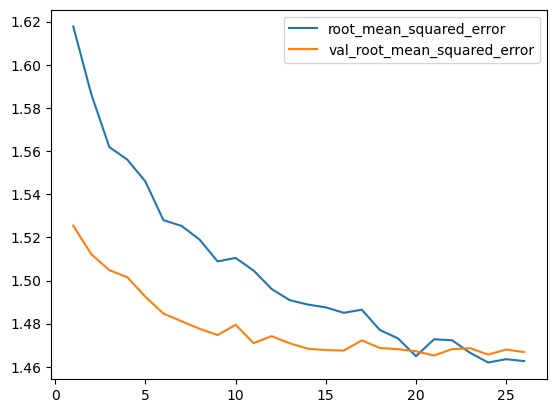

In [22]:
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['root_mean_squared_error', 'val_root_mean_squared_error']].plot();
print("Minimum validation root_mean_squared_error: {}".format(history_df['val_root_mean_squared_error'].min()))

In [23]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/22
612/612 [==============================] - 3s 5ms/step - loss: 4.7111 - root_mean_squared_error: 2.1484 - val_loss: 2.5856 - val_root_mean_squared_error: 1.5783
Epoch 2/22
612/612 [==============================] - 3s 5ms/step - loss: 2.7257 - root_mean_squared_error: 1.6217 - val_loss: 2.4443 - val_root_mean_squared_error: 1.5325
Epoch 3/22
612/612 [==============================] - 3s 5ms/step - loss: 2.6107 - root_mean_squared_error: 1.5856 - val_loss: 2.3938 - val_root_mean_squared_error: 1.5157
Epoch 4/22
612/612 [==============================] - 3s 5ms/step - loss: 2.5383 - root_mean_squared_error: 1.5626 - val_loss: 2.3714 - val_root_mean_squared_error: 1.5079
Epoch 5/22
612/612 [==============================] - 3s 5ms/step - loss: 2.5089 - root_mean_squared_error: 1.5527 - val_loss: 2.3389 - val_root_mean_squared_error: 1.4975
Epoch 6/22
612/612 [==============================] - 3s 5ms/step - loss: 2.4653 - root_mean_squared_error: 1.5388 - val_loss: 2.3122 - val_

In [24]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test RMSE]:", eval_result)

192/192 [==============================] - 1s 4ms/step - loss: 2.1879 - root_mean_squared_error: 1.4462
[test loss, test RMSE]: [2.1878631114959717, 1.4462144374847412]


In [25]:

y_train_pred = hypermodel.predict(X_train).flatten()
y_test_pred = hypermodel.predict(X_test).flatten()


192/192 [==============================] - 0s 1ms/step


In [26]:
print('Train: RMSE=', np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3),
    ' R2=', r2_score(y_train, y_train_pred).round(3))

print('Test: RMSE=', np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3),
    ' R2=', r2_score(y_test, y_test_pred).round(3))

Train: RMSE= 1.418  R2= 0.627
Test: RMSE= 1.446  R2= 0.615


In [27]:
residuals_test=y_test_pred-y_test
r_residuals_test=(residuals_test)/y_test*100

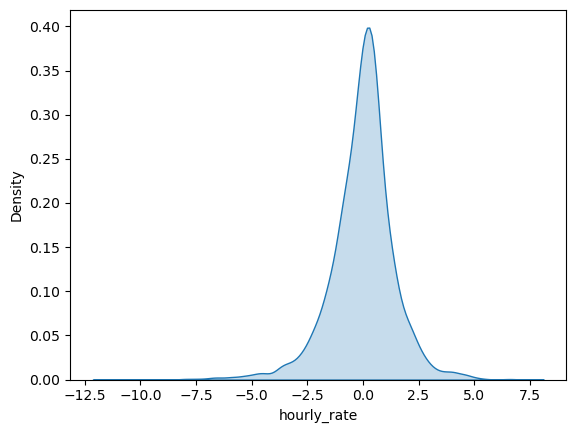

In [28]:
sns.kdeplot(residuals_test, fill=True);

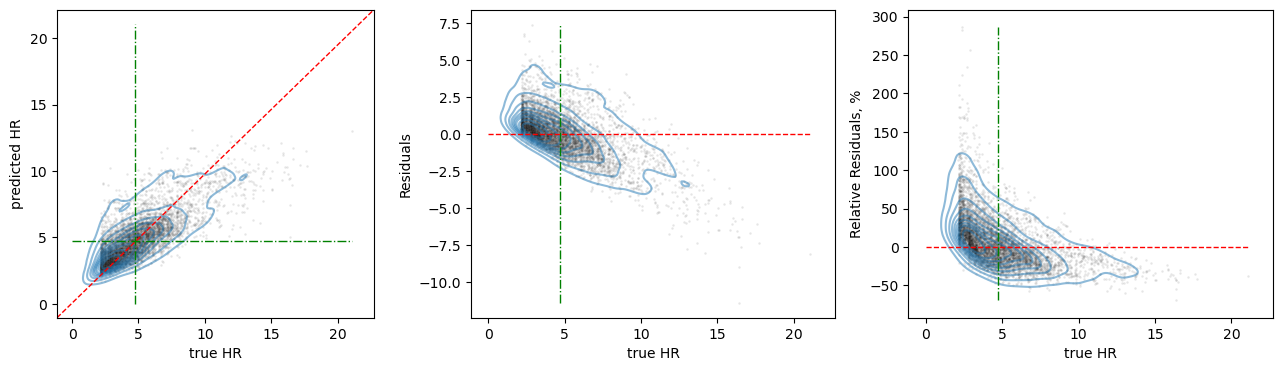

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharex=True)
sns.scatterplot(ax=ax[0], x=y_test, y=y_test_pred,  s=3, color='black', alpha=0.1)
sns.kdeplot(ax=ax[0],  x=y_test, y=y_test_pred, alpha=0.5 )
ax[0].set_xlabel('true HR')
ax[0].set_ylabel('predicted HR')
ax[0].set_aspect(aspect=1, adjustable=None, anchor=None, share=False)
ax[0].plot((0,1), (0, 1), transform=ax[0].transAxes, linestyle='--', color='r', lw=1)
ax[0].vlines(ymin=0, ymax=max(y_test) , x=y_train_mean, linestyle='-.', color='g', lw=1)
ax[0].hlines(xmin=0, xmax=max(y_test) , y=y_train_mean, linestyle='-.', color='g', lw=1)

sns.scatterplot(ax=ax[1],  x=y_test, y=residuals_test,  s=3, color='black', alpha=0.1)
sns.kdeplot(ax=ax[1], x=y_test, y=residuals_test, alpha=0.5 )
ax[1].set_xlabel('true HR')
ax[1].set_ylabel('Residuals')
ax[1].vlines(ymin=min(residuals_test), ymax=max(residuals_test) , x=y_train_mean, linestyle='-.', color='g', lw=1)
ax[1].hlines(xmin=0, xmax=max(y_test) , y=0, linestyle='--', color='r', lw=1)

sns.scatterplot(ax=ax[2],  x=y_test, y=r_residuals_test,  s=3, color='black', alpha=0.1)
sns.kdeplot(ax=ax[2],  x=y_test, y=r_residuals_test, alpha=0.5 )
ax[2].set_xlabel('true HR')
ax[2].set_ylabel('Relative Residuals, %')
ax[2].vlines(ymin=min(r_residuals_test), ymax=max(r_residuals_test) , x=y_train_mean, linestyle='-.', color='g', lw=1)
ax[2].hlines(xmin=0, xmax=max(y_test) , y=0, linestyle='--', color='r', lw=1);